n = 5の時、3000epoch走らせた結果が載っている（train_test_split使用）

面倒なので、まずは最大でも１色とする(n<=9)、手牌は14枚以下(m=3, 5, 8, 11, 14のみ)、同一牌は4枚(l = 4)でこれは固定。この条件でvalueを求める。



 **変数の意味**

- state : あがりに必要な枚数の手牌の状態

- hand : stateから一枚切った状態

### 必要な関数の再定義

In [14]:
from collections import defaultdict
def is_valid(seq, l=4): # 生成された組み合わせが手牌として妥当かどうかを判断する関数　tuple(seq)の一つ一つが一つの状態(手牌)に対応している
    counts = defaultdict(lambda: 0)
    for i in range(0, len(seq)):
        if i + 1 < len(seq) and seq[i] > seq[i + 1]: # 前半の条件はiが一番最後以外は常に成立、後半の条件は昇順に整列するための条件
            return False
        counts[seq[i]] += 1
        if (counts[seq[i]] > l): return False # 牌の上限枚数を超えたらFalse
    return True

import itertools
def number_state_slow(n,m,l): # 全ての手牌の組み合わせの数を出力する関数
    count = 0
    for seq in itertools.product(range(n), repeat = m): # 直積を作る関数, n=9 m=5 なら 9 ** 5 回繰り返す　
        if is_valid(seq,l):
            count += 1
            #print(list(seq))
    return count
    
def generate_all_l(n, m, l=4): # 全ての手牌の組み合わせをタプルで出力する関数
    gen_list = []
    for seq in itertools.product(range(n), repeat = m):
        if is_valid(seq, l):
            gen_list.append(seq)
    return gen_list

def states_to_hist(state_list, n): # 手牌(state)を、牌種ごとの枚数のリスト(長さn)に変換する関数
    hist_list = []
    for state in state_list:
        #print(state)
        ret = [0] * n # ret = [0,0,...,0]
        for c in state:
            ret[c] += 1
        hist_list.append(ret)
    return hist_list

def hand_to_prob_and_state(hand, state_nml, n, m, l=4): # ある手牌(hand)における、1枚ツモる時の遷移確率(prob)と手牌(state)のindexのタプルを出す関数
    ret = [l] * n  #  残り枚数を表すリスト
    for h in hand:
        ret[h] -= 1
    yama_sum = n * l - (m - 1)
    state_list = []
    for i in range(n):
        if ret[i] == 0: 
            continue
        prob = ret[i] / yama_sum # 遷移確率
        state = tuple(sorted(list(hand) + [i])) # 遷移後の手牌
        #print(state)
        state_index = state_nml.index(state) # 遷移後の手牌のindex
        #print(state_index)
        state_list.append((prob, state_index))
    return state_list

def state_to_hand(state): # ある手牌stateに遷移できるhandを出力する関数
    return list(set(tuple(state[:i] + state[i+1:]) for i in range(len(state)))) # i番目の要素を取り除く

def is_win_sub(hist, two, three):
    if any(x < 0 for x in hist):
        return False # この行を消したかったら、順子判定のところで手牌の枚数が負になるものを弾いておく
    if two == 0 and three == 0:
        return True
    i = next(i for i, x in enumerate(hist) if x > 0) # histの中でx>０を満たす最小のindexを持ってくる
    if two > 0 and hist[i] >= 2 and is_win_sub([x - 2 if i == j else x for j, x in enumerate(hist)], two - 1, three): # 雀頭
        return True
    if three > 0 and hist[i] >= 3 and is_win_sub([x - 3 if i == j else x for j, x in enumerate(hist)], two, three - 1): # 刻子
        return True
    if three > 0 and i + 2 < len(hist) and is_win_sub([x -1 if i <= j <= i + 2 else x for j, x in enumerate(hist)], two, three - 1): # 順子
        return True
    return False

def is_win_main(hist):
    n_two = 1 if sum(hist) % 3 == 2 else 0
    n_three = sum(hist) // 3
    return is_win_sub(hist, n_two, n_three)

def value_iteration(n, m, l, gamma):
    state_nml = generate_all_l(n, m, l)
    hand_nml = generate_all_l(n, m-1, l)
    hist_nml = states_to_hist(state_nml, n)
    is_win_nml = [is_win_main(hist) for hist in hist_nml]
    h2ps_nml = [hand_to_prob_and_state(hand, state_nml, n, m, l) for hand in hand_nml]
    s2h_nml = [[hand_nml.index(hand) for hand in state_to_hand(state)] for state in state_nml]
    value_hand = [0] * len(hand_nml)
    n_hand = len(hand_nml)
    value_state = [1 if is_win_nml[i] else 0 for i in range(len(state_nml))] # あがっていればvalueは1、いなければ0
    n_state = len(state_nml)
    theta = 1e-6
    while True:
        print('iteration')
        delta = 0
        for i in range(n_hand):
            old_v = value_hand[i]
            value_hand[i] = sum(p * value_state[n] for (p, n) in h2ps_nml[i])
            delta = max(delta, abs(old_v - value_hand[i]))
        if delta < theta: break
        for i in range(n_state):
            if is_win_nml[i]: continue
            value_state[i] = max(gamma * value_hand[n] for n in s2h_nml[i])
    return value_hand # 各valueのhandをリストにして返す

In [15]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import random
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import time

random_seed = 34
np.random.seed(random_seed)
tf.set_random_seed(random_seed)

In [16]:
def one_hot_vector1(hands, n): # 手牌の中の牌一つ一つをone-hotにした(手牌１つがn * m-1の行列に対応)
    results = np.zeros((len(hands), n, len(hands[0])))
    for i in range(len(hands)):
        for j, hand_i in enumerate(hands[i]):
            results[i][hand_i][j] = 1
    return results

def one_hot_vector2(hists, n, l=4): # histをそのままone-hotにした(手牌１つがn * l + 1の行列に対応)
    results = np.zeros((len(hists), n, l + 1))
    for i in range(len(hists)):
        for j, hist_i in enumerate(hists[i]):
            results[i][j][hist_i] = 1
    return results

def one_hot_vector3(hists, n, l=4): # 上に近いけど、持ってる枚数より小さい数も1で埋めた(手牌１つがn * lの行列に対応)
    results = np.zeros((len(hists), n, l))
    for i in range(len(hists)):
        for j, hist_i in enumerate(hists[i]):
            if hist_i == 0:
                continue
            else:
                results[i][j][:hist_i] = 1
    return results

### 捨て牌ベクトルの作成

In [30]:
n = 9
m = 5
l = 4

value_hand_nml = value_iteration(n, m, l, 0.9)
state_nml = generate_all_l(n, m, l)
hand_nml = generate_all_l(n, m - 1, l)
#print(len(hand_nml))
#print(hand_nml)
#print(value_hand_nml)

def state_to_hist(state, n): # 手牌(state)を、牌種ごとの枚数のリスト(長さn)に変換する関数
    hist = [0] * n # hist = [0,0,...,0]
    for c in state:
        hist[c] += 1
    return hist

# stateとその時にvalueが最大となる捨て牌のタプルを入れたリスト max_value_discard_list = [((0, 0, 0, 0, 1), {0}), ((0, 0, 0, 0, 2), {0}), ... ,((7, 8, 8, 8, 8), {8})]
# state_nmlのうち、あがり形を抜いたもの discard_state_nml = [(0, 0, 0, 0, 1), (0, 0, 0, 0, 2), ..., (7, 8, 8, 8, 8)]
def states_to_max_value_list(state_nml, hand_nml, value_hand_nml, n, m, l=4):
    max_value_list = []
    discard_state_nml = []
    hist_nml = states_to_hist(state_nml, n)
    for i, hist in enumerate(hist_nml):        
        if is_win_main(hist):
            continue # あがっているstateの時は何も入れない
        else:
            max_value = 0
            max_p = []
            for j in range(m):
                state = state_nml[i]
                hand = state[:j] + state[j+1:]
                ind = hand_nml.index(tuple(hand))
                hand_val = value_hand_nml[ind]
                if max_value < hand_val:
                    max_p = {state[j]}
                    max_value = hand_val
                elif round(max_value, 5) == round(hand_val, 5): # 小数点以下5桁まで同じなら同じとみなす
                    max_p.add(state[j])
            discard_state_nml.append(state_nml[i])
            max_value_list.append(tuple((state_nml[i], max_p)))
    return max_value_list, discard_state_nml # 正直discard_hist_nmlを出す方が早い

# 各stateにおいて、出力してほしい捨て牌の確率分布を出力する
def discard_ans_prob_vector(max_value_discard_list, n, m, l):
    discard_vector = []
    for i, discard in max_value_discard_list:
        v = [0] * n
        num = len(discard)
        for p in discard:
            v[p] = 1 / num # 答えの数で割った値を教師とする  こうしないと学習がうまくいかない?
            #v[p] = 1
        discard_vector.append(v)
    return discard_vector

max_value_discard_list, discard_state_nml = states_to_max_value_list(state_nml, hand_nml, value_hand_nml, n, m, l)
#for i in max_value_discard_list: print(i) 
discard_hist_nml = states_to_hist(discard_state_nml, n)

#one_hot_discard_state_nml1 = one_hot_vector1(discard_state_nml, n)
#one_hot_discard_state_nml2 = one_hot_vector2(discard_hist_nml, n, l)
#one_hot_discard_state_nml3 = one_hot_vector3(discard_hist_nml, n, l)
discard_ans_vector_nml = np.array(discard_ans_prob_vector(max_value_discard_list, n, m, l))
#print(discard_ans_vector_nml)

iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
((0, 0, 0, 0, 1), {0})
((0, 0, 0, 0, 2), {0})
((0, 0, 0, 0, 3), {0})
((0, 0, 0, 0, 4), {0})
((0, 0, 0, 0, 5), {0})
((0, 0, 0, 0, 6), {0})
((0, 0, 0, 0, 7), {0})
((0, 0, 0, 0, 8), {0})
((0, 0, 0, 1, 3), {3})
((0, 0, 0, 1, 4), {4})
((0, 0, 0, 1, 5), {5})
((0, 0, 0, 1, 6), {6})
((0, 0, 0, 1, 7), {7})
((0, 0, 0, 1, 8), {8})
((0, 0, 0, 2, 3), {0})
((0, 0, 0, 2, 4), {4})
((0, 0, 0, 2, 5), {5})
((0, 0, 0, 2, 6), {6})
((0, 0, 0, 2, 7), {7})
((0, 0, 0, 2, 8), {8})
((0, 0, 0, 3, 4), {0})
((0, 0, 0, 3, 5), {3})
((0, 0, 0, 3, 6), {3})
((0, 0, 0, 3, 7), {7})
((0, 0, 0, 3, 8), {8})
((0, 0, 0, 4, 5

In [18]:
class PrintDot(keras.callbacks.Callback):
    def __init__(self, epochs):
        self.epochs = epochs
        
    def on_epoch_end(self, epoch, logs):
        if epoch % (self.epochs // 5) == 0: print(logs.get('loss'))
        if epoch % 10 == 0: print('.', end='')

# # 正解率を出す関数
# def acc_score(pr_arg_list): 
#     tr_count = 0
#     fal_count = 0
#     for i, j in zip(pr_arg_list, max_value_discard_list):
#         #print(i, j)
#         if i in j[1]:
#             tr_count += 1
#         else:
#             fal_count += 1
#     print('true count {}  false count {}'.format(tr_count, fal_count))
#     print('accuracy rate', tr_count / (tr_count + fal_count))
#     return tr_count / (tr_count + fal_count)
  
# def make_pred_arg_list(predictions):
#     pr_arg_list = []
#     for i, state in enumerate(discard_state_nml):
#         pra = np.argmax(predictions[i])
#         if pra not in state:
#             max_val = 0
#             max_tile = 0
#             for s in state:
#                 if predictions[i][s] > max_val:
#                     max_val = predictions[i][s]
#                     max_tile = s
#             pra = max_tile
#         pr_arg_list.append(pra)
#     return pr_arg_list

# # one_hot_discard_state_nml1を普通のstate_nmlに直す
# def one_hot_to_normal1(one_hot_discard_state1):
#     normal_state_nml1 = []
#     for st in one_hot_discard_state1:
#         state = []
#         print(st)
#         for i in range(m):
#             state.append(np.argmax(st[:,i]))
#         normal_state_nml1.append(state)
#     return normal_state_nml1

# # one_hot_discard_state_nml2を普通のstate_nmlに直す
# def one_hot_to_normal2(one_hot_discard_state2):
#     normal_state_nml2 = []
#     for st in one_hot_discard_state2:
#         state = []
#         print(st)
#         for i in range(len(st)):
#             num = np.argmax(st[i])
#             for j in range(num):
#                 state.append(i)
#         normal_state_nml2.append(state)
#     return normal_state_nml2

# # one_hot_discard_state_nml3を普通のstate_nmlに直す
# def one_hot_to_normal3(one_hot_discard_state3):
#     normal_state_nml3 = []
#     for st in one_hot_discard_state3:
#         state = []
#         print(st)
#         for i in range(len(st)):
#             num = int(sum(st[i]))
#             for j in range(num):
#                 state.append(i)
#         normal_state_nml3.append(state)
#     return normal_state_nml3

# discard_state_nmlをone_hot化する関数
def one_hot(discard_state_nml, num):
    if num == 1:
        return one_hot_vector1(discard_state_nml, n)
    elif num == 2:
        discard_hist_nml = states_to_hist(discard_state_nml, n)
        return one_hot_vector2(discard_hist_nml, n, l)
    else:
        discard_hist_nml = states_to_hist(discard_state_nml, n)
        return one_hot_vector3(discard_hist_nml, n, l)

# predictionsから求めた捨て牌のリストを返す関数
def make_pred_arg_list_split(predictions, discard_state_test):
    pred_arg_list = []
    for i  in range(len(predictions)):
        tile = np.argmax(predictions[i])
        if tile not in discard_state_test[i]:
            max_val = 0
            max_tile = 0
            for t in discard_state_test[i]:
                if predictions[i][t] > max_val:
                    max_val = predictions[i][t]
                    max_tile = t
            tile = max_tile
        pred_arg_list.append(tile)
    return pred_arg_list

# 正解率を返す関数
def acc_score_split(pred_arg_list, discard_state_test): 
    tr_count = 0
    fal_count = 0
    for i, pred_arg in enumerate(pred_arg_list):
        #print(i, j)
        for state, discard_set in max_value_discard_list:
            if discard_state_test[i] == state:
                if pred_arg in discard_set:
                    tr_count += 1
                else:
                    fal_count += 1
    print('true count {}  false count {}'.format(tr_count, fal_count))
    print('accuracy rate', tr_count / (tr_count + fal_count))
    return tr_count / (tr_count + fal_count)

### Policy networkの作成

In [33]:
def train_policy_network(num, Dence_number_list, input_shape, n_trials, EPOCHS):
    start_time = time.time()
    result_mean_dict  = {}
    result_std_dict = {}
    pred_acc_dict = {}
    time_dict = {}
    plt.figure()
    
    for d_num in Dence_number_list:
        def build_model():
            model = keras.Sequential([
                layers.Flatten(input_shape=input_shape),
                layers.Dense(d_num, activation='relu'),
                layers.Dense(n, activation='softmax'),
            ])
            optimizer = keras.optimizers.RMSprop(0.001)
            model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
            return model

        sum_acc_result = pd.Series([0] * EPOCHS)
        final_acc_results = []
        pred_acc_results = []
        for i in range(n_trials):
            model = build_model()
            if i == 0:
                model.summary()
            discard_state_train, discard_state_test, discard_ans_vector_train, discard_ans_vector_test = train_test_split(discard_state_nml, discard_ans_vector_nml, test_size=0.25)
            #print(discard_state_train[:5])
            #print(discard_ans_vector_train[:5])
            one_hot_discard_state_train = one_hot(discard_state_train, num)
            one_hot_discard_state_test = one_hot(discard_state_test, num)
            history = model.fit(one_hot_discard_state_train, discard_ans_vector_train, epochs=EPOCHS, validation_split = 0, verbose=0, callbacks=[PrintDot(EPOCHS)])
            hist = pd.DataFrame(history.history)
            hist['epoch'] = history.epoch
            print('\n',hist.tail())
            sum_acc_result += hist['categorical_accuracy']
            final_acc_results.append(hist['categorical_accuracy'][EPOCHS-1])
            predictions = model.predict(one_hot_discard_state_test)
            pred_arg_list = make_pred_arg_list_split(predictions, discard_state_test)
            #print(predictions[:5], discard_state_test[:5], pred_arg_list[:5])
            pred_acc_results.append(acc_score_split(pred_arg_list, discard_state_test))
            print()

        result_mean_dict[d_num] = round(np.mean(final_acc_results), 5)
        result_std_dict[d_num] = round(np.std(final_acc_results), 6)
        pred_acc_dict[d_num] = round(np.mean(pred_acc_results), 4)
        time_dict[d_num] = round(time.time() - start_time, 1)
        plt.plot(hist['epoch'], sum_acc_result / n_trials, label=str(d_num))

    plt.xlabel('Epoch')
    plt.ylabel('categorical accuracy')
    plt.legend()

    print('result acc mean\n', result_mean_dict)
    print('result acc std\n', result_std_dict)
    print('pred accuracy rate(mean)\n', pred_acc_dict)
    print('time (sec)\n', time_dict)

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_53 (Flatten)         (None, 45)                0         
_________________________________________________________________
dense_106 (Dense)            (None, 1000)              46000     
_________________________________________________________________
dense_107 (Dense)            (None, 9)                 9009      
Total params: 55,009
Trainable params: 55,009
Non-trainable params: 0
_________________________________________________________________
1.8152659509674394
............................................................0.0248187089508971
............................................................0.023459128944476704
............................................................0.021225469880135628
............................................................0.02077093353122765
.......................................

............................................................0.021003168732242138
............................................................0.02028032484668923
............................................................0.01957358354898218
............................................................
           loss  categorical_accuracy  epoch
2995  0.019464              0.988331   2995
2996  0.019616              0.984831   2996
2997  0.019600              0.988331   2997
2998  0.019513              0.985998   2998
2999  0.019600              0.987165   2999
true count 196  false count 90
accuracy rate 0.6853146853146853

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_63 (Flatten)         (None, 45)                0         
_________________________________________________________________
dense_126 (Dense)            (None, 300)               13800     
_______________

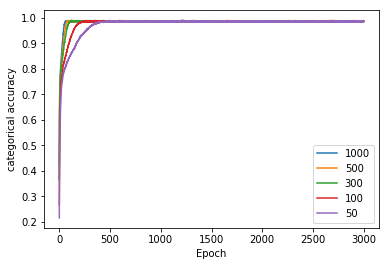

In [40]:
num = 1
Dence_number_list = [1000, 500, 300, 100, 50]
input_shape = (n, m)
n_trials = 5
EPOCHS = 3000
train_policy_network(num, Dence_number_list, input_shape, n_trials, EPOCHS)

Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_78 (Flatten)         (None, 45)                0         
_________________________________________________________________
dense_156 (Dense)            (None, 1000)              46000     
_________________________________________________________________
dense_157 (Dense)            (None, 9)                 9009      
Total params: 55,009
Trainable params: 55,009
Non-trainable params: 0
_________________________________________________________________
1.696163342602751
............................................................0.022315953852185794
............................................................0.020474738111078986
............................................................0.02001539676024773
............................................................0.0202758079927179
........................................

............................................................0.02041131033642315
............................................................0.019530678991494466
............................................................0.019489397193730135
............................................................
           loss  categorical_accuracy  epoch
2995  0.019309              0.983664   2995
2996  0.019261              0.988331   2996
2997  0.019685              0.985998   2997
2998  0.019104              0.987165   2998
2999  0.019466              0.984831   2999
true count 224  false count 62
accuracy rate 0.7832167832167832

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_88 (Flatten)         (None, 45)                0         
_________________________________________________________________
dense_176 (Dense)            (None, 300)               13800     
______________

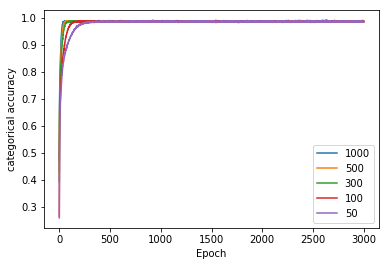

In [41]:
num = 2
#Dence_number_list = [100]
input_shape = (n, l+1)
#n_trials = 3
#EPOCHS = 100
train_policy_network(num, Dence_number_list, input_shape, n_trials, EPOCHS)

Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_103 (Flatten)        (None, 36)                0         
_________________________________________________________________
dense_206 (Dense)            (None, 1000)              37000     
_________________________________________________________________
dense_207 (Dense)            (None, 9)                 9009      
Total params: 46,009
Trainable params: 46,009
Non-trainable params: 0
_________________________________________________________________
1.860298220168195
............................................................0.020405112748256942
............................................................0.01931036086429031
............................................................0.018317505108410622
............................................................0.017990921105608505
.....................................

............................................................0.01866311197158245
............................................................0.017989900834591354
............................................................0.018116188268539227
............................................................
           loss  categorical_accuracy  epoch
2995  0.018341              0.985998   2995
2996  0.017706              0.989498   2996
2997  0.017819              0.987165   2997
2998  0.018050              0.988331   2998
2999  0.017921              0.987165   2999
true count 216  false count 70
accuracy rate 0.7552447552447552

Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_113 (Flatten)        (None, 36)                0         
_________________________________________________________________
dense_226 (Dense)            (None, 300)               11100     
_____________

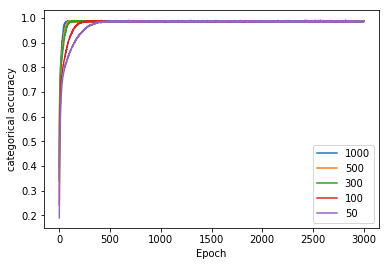

In [42]:
num = 3
#Dence_number_list = [100]
input_shape = (n, l)
#n_trials = 3
#EPOCHS = 100
train_policy_network(num, Dence_number_list, input_shape, n_trials, EPOCHS)

### n=8にしてみる

In [44]:
n = 9
m = 8
l = 4

value_hand_nml = value_iteration(n, m, l, 0.9)
state_nml = generate_all_l(n, m, l)
hand_nml = generate_all_l(n, m - 1, l)
#print(len(hand_nml))
#print(hand_nml)
#print(value_hand_nml)

max_value_discard_list, discard_state_nml = states_to_max_value_list(state_nml, hand_nml, value_hand_nml, n, m, l)
print(max_value_discard_list[:10])
discard_hist_nml = states_to_hist(discard_state_nml, n)
discard_ans_vector_nml = np.array(discard_ans_prob_vector(max_value_discard_list, n, m, l))
#print(discard_ans_vector_nml)

iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
[((0, 0, 0, 0, 1, 1, 1, 1), {0, 1}), ((0, 0, 0, 0, 1, 1, 1, 3), {0}), ((0, 0, 0, 0, 1, 1, 1, 4), {0}), ((0, 0, 0, 0, 1, 1, 1, 5), {0}), ((0, 0, 0, 0, 1, 1, 1, 6), {0}), ((0, 0, 0, 0, 1, 1, 1, 7), {0}), ((0, 0, 0, 0, 1, 1, 1, 8), {0}), ((0, 0, 0, 0, 1, 1, 2, 3), {0}), ((0, 0, 0, 0, 1, 1, 2, 4), {0}), ((0, 0, 0, 0, 1, 1, 2, 5), {5})]


Model: "sequential_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_128 (Flatten)        (None, 72)                0         
_________________________________________________________________
dense_256 (Dense)            (None, 100)               7300      
_________________________________________________________________
dense_257 (Dense)            (None, 9)                 909       
Total params: 8,209
Trainable params: 8,209
Non-trainable params: 0
_________________________________________________________________
1.7019860300138265
..0.732759614012817
..0.5899637474617133
..0.5103197680972015
..0.45786666454697833
..
         loss  categorical_accuracy  epoch
95  0.425502              0.843409     95
96  0.423215              0.842126     96
97  0.420839              0.842639     97
98  0.420377              0.847645     98
99  0.416851              0.847003     99
true count 1913  fals

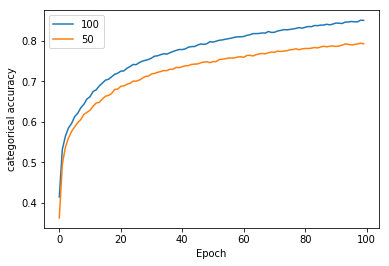

In [45]:
num = 1
Dence_number_list = [100, 50]
input_shape = (n, m)
n_trials = 2
EPOCHS = 100
train_policy_network(num, Dence_number_list, input_shape, n_trials, EPOCHS)

Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_132 (Flatten)        (None, 45)                0         
_________________________________________________________________
dense_264 (Dense)            (None, 100)               4600      
_________________________________________________________________
dense_265 (Dense)            (None, 9)                 909       
Total params: 5,509
Trainable params: 5,509
Non-trainable params: 0
_________________________________________________________________
1.5624086095010372
..0.5330696144285778
..0.407143762678256
..0.3388208686815822
..0.2895352090450111
..
         loss  categorical_accuracy  epoch
95  0.261747              0.907842     95
96  0.260134              0.909383     96
97  0.257330              0.909896     97
98  0.257883              0.912591     98
99  0.254528              0.909768     99
true count 2102  false

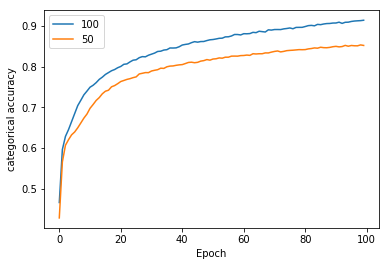

In [46]:
num = 2
#Dence_number_list = [100, 50]
input_shape = (n, l+1)
#n_trials = 2
#EPOCHS = 100
train_policy_network(num, Dence_number_list, input_shape, n_trials, EPOCHS)

Model: "sequential_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_137 (Flatten)        (None, 36)                0         
_________________________________________________________________
dense_274 (Dense)            (None, 100)               3700      
_________________________________________________________________
dense_275 (Dense)            (None, 9)                 909       
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________
1.7064958924644948
..0.6805504221249692
..0.5153777753032228
..0.4308287122408427
..0.37938352102661693
..
         loss  categorical_accuracy  epoch
95  0.350675              0.873572     95
96  0.346917              0.874085     96
97  0.348170              0.873059     97
98  0.343951              0.873700     98
99  0.342854              0.877166     99
true count 2067  fal

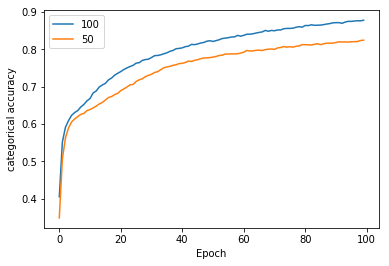

In [48]:
num = 3
#Dence_number_list = [100, 50]
input_shape = (n, l)
#n_trials = 2
#EPOCHS = 100
train_policy_network(num, Dence_number_list, input_shape, n_trials, EPOCHS)